In [1]:
!nvidia-smi

Tue Jun 18 00:45:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0              21W /  90W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-" -O vehicle-counting.mp4 && rm -rf /tmp/cookies.txt

--2024-05-19 07:00:00--  https://docs.google.com/uc?export=download&confirm=&id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
Resolving docs.google.com (docs.google.com)... 108.177.127.102, 108.177.127.113, 108.177.127.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download [following]
--2024-05-19 07:00:01--  https://drive.usercontent.google.com/download?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.18.132, 2a00:1450:4013:c18::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.18.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35345757 (34M) [video/mp4]
Saving to: ‘vehicle-counting.mp4’

vehicle-counting.mp 100%[===================>]  33.71M   150MB/s 

In [ ]:
SOURCE_VIDEO_PATH = "/content/trafficsignal4.mp4"

In [ ]:
!pip install ultralytics==8.1.5

In [ ]:
import os
HOME = os.getcwd()
%pwd

'/content'

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

/content
fatal: destination path 'ByteTrack' already exists and is not an empty directory.
/content/ByteTrack


In [ ]:
# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!pip install numpy==1.23.3
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
!pip install supervision==0.1.0
from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

MODEL = "yolov8x.pt"
from ultralytics import YOLO
model = YOLO(MODEL)
model.fuse()
%cd /content
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH}

supervision.__version__: 0.1.0
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs
/content
Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

video 1/1 (1/3349) /content/trafficsignal4.mp4: 640x384 1 person, 2 cars, 1 traffic light, 324.3ms
video 1/1 (2/3349) /content/trafficsignal4.mp4: 640x384 1 person, 1 car, 1 traffic light, 62.1ms
video 1/1 (3/3349) /content/trafficsignal4.mp4: 640x384 1 person, 1 car, 1 traffic light, 62.1ms
video 1/1 (4/3349) /content/trafficsignal4.mp4: 640x384 1 person, 2 cars, 49.1ms
video 1/1 (5/3349) /content/trafficsignal4.mp4: 640x384 1 person, 1 car, 1 traffic light, 43.3ms
video 1/1 (6/3349) /content/trafficsignal4.mp4: 640x384 1 person, 1 car, 40.9ms
video 1/1 (7/3349) /content/trafficsignal4.mp4: 640x384 1 person, 2 cars, 1 traffic light, 40.4ms
video 1/1 (8/3349) /content/trafficsignal4.mp4: 640x384 

In [ ]:
import numpy as np

print(np.__version__)
from supervision.video.source import get_video_frames_generator
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]

1.23.3



0: 640x384 1 person, 2 cars, 1 traffic light, 57.6ms
Speed: 2.7ms preprocess, 57.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)


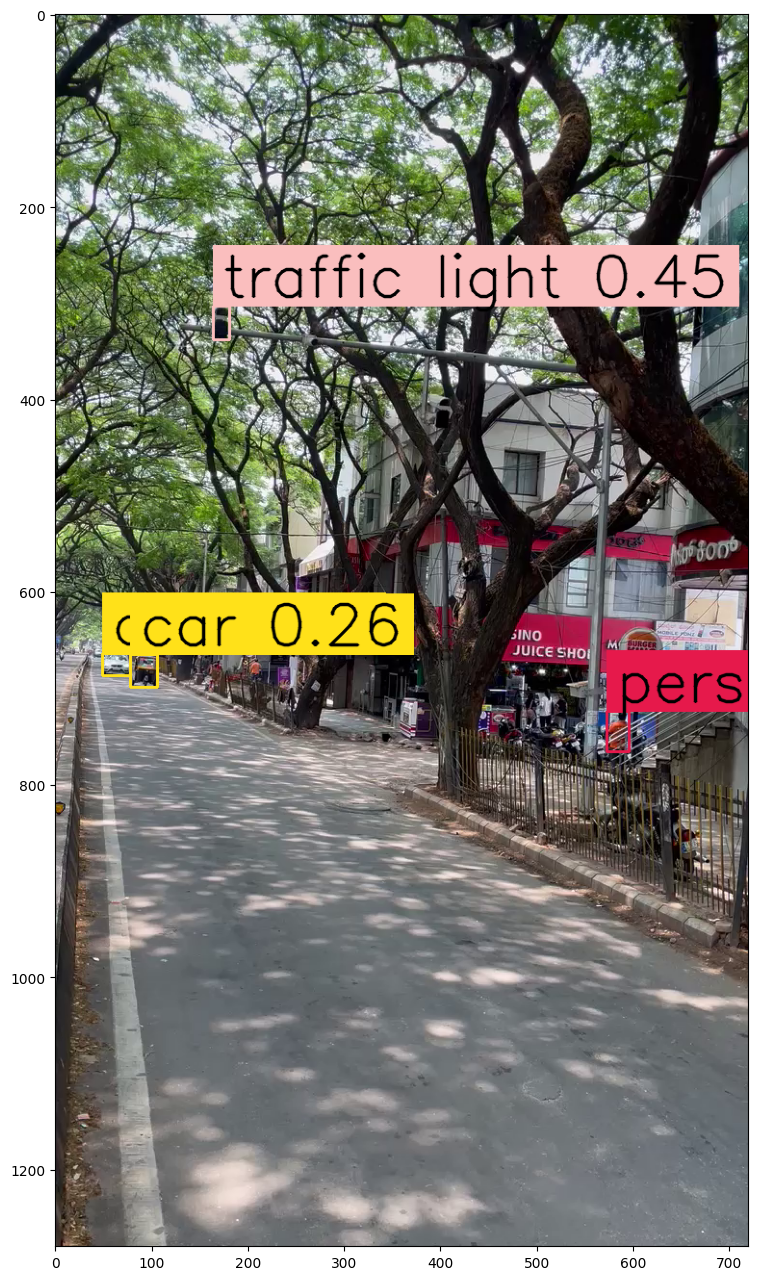

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
SOURCE_VIDEO_PATH = "/content/trafficsignal2.mp4"

In [ ]:
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from supervision.video.sink import VideoSink
import numpy as np
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

TARGET_VIDEO_PATH = "trafficsignal4result.mp4"
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=720, height=1280, fps=26, total_frames=3349)

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

# Assuming BYTETracker, VideoInfo, get_video_frames_generator, LineCounter, BoxAnnotator, LineCounterAnnotator, VideoSink, and other necessary imports are done
frame_number=0
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Open a file for writing the information
with open('frame_info.txt', 'w') as file:
    # open target video file
    with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
        # loop over video frames
        for frame in tqdm(generator, total=video_info.total_frames):
            # model prediction on single frame and conversion to supervision Detections
            results = model(frame)
            detections = Detections(
                xyxy=results[0].boxes.xyxy.cpu().numpy(),
                confidence=results[0].boxes.conf.cpu().numpy(),
                class_id=results[0].boxes.cls.cpu().numpy().astype(int)
            )
            # filtering out detections with unwanted classes
            mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
            detections.filter(mask=mask, inplace=True)
            # tracking detections
            tracks = byte_tracker.update(
                output_results=detections2boxes(detections=detections),
                img_info=frame.shape,
                img_size=frame.shape
            )
            tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
            detections.tracker_id = np.array(tracker_id)
            # filtering out detections without trackers
            mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
            detections.filter(mask=mask, inplace=True)
            # format custom labels
            labels = [
                f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                for _, confidence, class_id, tracker_id
                in detections
            ]
            # updating line counter
            line_counter.update(detections=detections)
            # annotate and display frame
            frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
            line_annotator.annotate(frame=frame, line_counter=line_counter)
            sink.write_frame(frame)

            # Write information to the file
            for _, confidence, class_id, tracker_id in detections:
                # Assuming CLASS_NAMES_DICT is a dictionary mapping class IDs to class names
                class_name = CLASS_NAMES_DICT.get(class_id, 'Unknown')
                file.write(f"Frame: {frame_number},Class: {class_name}, Class ID: {class_id}, Tracker ID: {tracker_id}, Confidence: {confidence:.2f}\n")
            # Increment frame_number for the next iteration
            frame_number += 1


  0%|          | 0/3349 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 640x384 5 persons, 8 cars, 2 motorcycles, 1 bus, 31.0ms
Speed: 2.3ms preprocess, 31.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 8 cars, 1 motorcycle, 1 bus, 30.9ms
Speed: 3.2ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 8 cars, 2 motorcycles, 1 bus, 29.9ms
Speed: 2.2ms preprocess, 29.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 4 persons, 8 cars, 2 motorcycles, 1 bus, 30.0ms
Speed: 2.3ms preprocess, 30.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 5 persons, 8 cars, 2 motorcycles, 1 bus, 31.1ms
Speed: 4.2ms preprocess, 31.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 6 persons, 8 cars, 2 motorcycles, 1 bus, 31.4ms
Speed: 2.9ms preprocess, 31.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x3